# **0. Introduction**

This notebook aims to predict customer churn in the banking industry. In recent decades, the options for customers to store their money has been rapidly increasing. Customer churn has been one of the top issues for many banks. The motivation for this research is to leverage machine learning methods to predict churn, assisting banks in preemptive engagement with at-risk customers.

The dataset used can be downloaded from here: https://www.kaggle.com/competitions/playground-series-s4e1/data

In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.svm import SVC

import warnings
# Filter out warnings
warnings.filterwarnings("ignore")

# **1. Exploratory Data Analysis**

## **1.1 Understand the Dataset**

### **1.1.1 Review dataset dimensions**

In [2]:
# Load the dataset
df = pd.read_csv('bank churn.csv')

# Examine the dimension of the dataset
df.shape

(165034, 14)

The dataset contains more than 160,000 rows, which is quite enough to build a machine learning model. It has 14 columns, 10 of which (`CreditScore`, `Geography`, `Gender`, `Age`, `Tenure`, `Balance`, `NumOfProducts`, `HasCrCard`, `IsActiveMember`, `EstimatedSalary`) are useful features and one of them is the target variable `Exited` indicating whether the customer has exited the bank or not.

From the following lines, we can observe that `HasCrCard`, `IsActiveMember`, `Exited` are already encoded as 0 or 1.

In [3]:
# Examine top 10 rows of the dataset
df.head(10)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1,0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1,1,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1,0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1,1,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1,1,15068.83,0
5,5,15771669,Genovese,588,Germany,Male,36.0,4,131778.58,1,1,0,136024.31,1
6,6,15692819,Ch'ang,593,France,Female,30.0,8,144772.69,1,1,0,29792.11,0
7,7,15669611,Chukwuebuka,678,Spain,Male,37.0,1,138476.41,1,1,0,106851.60,0
8,8,15691707,Manna,676,France,Male,43.0,4,0.00,2,1,0,142917.13,0
9,9,15591721,Cattaneo,583,Germany,Male,40.0,4,81274.33,1,1,1,170843.07,0


In [4]:
# Explore taget variable
print(df.Exited.value_counts())
print(round(sum(df['Exited'])/len(df), 4))

Exited
0    130113
1     34921
Name: count, dtype: int64
0.2116


Around 21.16% of customers have exited the bank. There is an imbalance problem in this dataset. This will be solved through up/down-sampling on training data only (not on testing data) in later stages.

### **1.1.2 Identify feature types (numerical, categorical)**

In [5]:
# check the data types: columns with mixed types are stored with the object dtype.
df.dtypes

id                   int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

The feature types are generally what we would normally expect. Numerical features include: `CreditScore`, `Age`, `Tenure`, `Balance`, `NumOfProducts`, `EstimatedSalary`. Categorical features include: `Geography`, `Gender`, `HasCrCard`, `IsActiveMember`. In these categorical features, `Geography` and `Gender` should be changed to "category" format.

# **1.2 Data Cleaning**

### **1.2.1 Check and handling missing values (numerical, categorical)**

In [6]:
# Check missing values
null_sum = df.isnull().sum()
null_sum

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

There is no missing values in this dataset, as observed from the above result and described from the original source: https://www.kaggle.com/competitions/playground-series-s4e1/data.

This dataset is generated from a deep learning model trained on the original "Bank Customer Churn Prediction" dataset from Kaggle.

### **1.2.2 Detect and Handle Outliers (categorical)**

In [7]:
# count the #samples fall into each category
print(df['Geography'].value_counts())
print()
print("Percentage of customers in France: {}".format(round(sum(df['Geography']=='France')/len(df), 4)))
print("Percentage of customers in Spain: {}".format(round(sum(df['Geography']=='Spain')/len(df), 4)))
print("Percentage of customers in Germany: {}".format(round(sum(df['Geography']=='Germany')/len(df), 4)))

Geography
France     94215
Spain      36213
Germany    34606
Name: count, dtype: int64

Percentage of customers in France: 0.5709
Percentage of customers in Spain: 0.2194
Percentage of customers in Germany: 0.2097


A larger amount of customers are located in France, while the number of customers located in Spain and Germany are very close.

In [8]:
# count the #samples fall into each category
print(df['Gender'].value_counts())
print()
print("Percentage of male customers: {}".format(round(sum(df['Gender']=='Male')/len(df), 4)))
print("Percentage of female customers: {}".format(round(sum(df['Gender']=='Female')/len(df), 4)))

Gender
Male      93150
Female    71884
Name: count, dtype: int64

Percentage of male customers: 0.5644
Percentage of female customers: 0.4356


There are more male observations than female observations.

In [9]:
# count the #samples fall into each category
print(df['HasCrCard'].value_counts())
print()
print("Percentage of customers who own a credit card: {}".format(round(sum(df['HasCrCard']==1)/len(df), 4)))
print("Percentage of customers who do not own a credit card: {}".format(round(sum(df['HasCrCard']==0)/len(df), 4)))

HasCrCard
1    124428
0     40606
Name: count, dtype: int64

Percentage of customers who own a credit card: 0.754
Percentage of customers who do not own a credit card: 0.246


Around 75% of the customers do have a credit card.

In [10]:
# count the #samples fall into each category
print(df['IsActiveMember'].value_counts())
print()
print("Percentage of customers who are active members: {}".format(round(sum(df['IsActiveMember']==1)/len(df), 4)))
print("Percentage of customers who are not active members: {}".format(round(sum(df['IsActiveMember']==0)/len(df), 4)))

IsActiveMember
0    82885
1    82149
Name: count, dtype: int64

Percentage of customers who are active members: 0.4978
Percentage of customers who are not active members: 0.5022


The distribution for whether the customer is an active member is quite even.

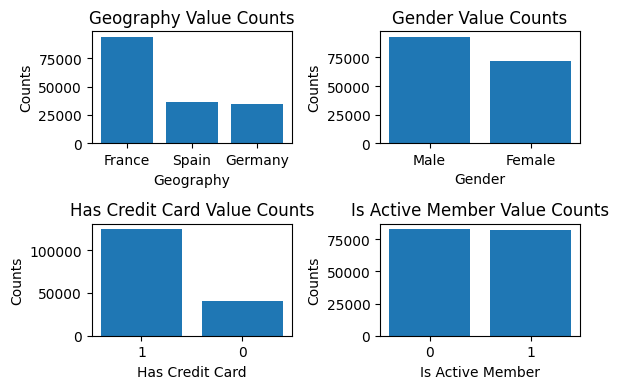

In [11]:
# Create a 2x2 grid of axes
fig, axs = plt.subplots(2, 2, figsize=(6, 4))  # You can adjust the figsize to fit your display

# Plot on each subplot
axs[0, 0].bar(df['Geography'].value_counts().index, df['Geography'].value_counts().values)
axs[0, 0].set_title('Geography Value Counts')
axs[0, 0].set_xlabel('Geography')
axs[0, 0].set_ylabel('Counts')

axs[0, 1].bar(df['Gender'].value_counts().index, df['Gender'].value_counts().values)
axs[0, 1].set_title('Gender Value Counts')
axs[0, 1].set_xlabel('Gender')
axs[0, 1].set_ylabel('Counts')

axs[1, 0].bar(df['HasCrCard'].value_counts().index.astype(str), df['HasCrCard'].value_counts().values)
axs[1, 0].set_title('Has Credit Card Value Counts')
axs[1, 0].set_xlabel('Has Credit Card')
axs[1, 0].set_ylabel('Counts')

axs[1, 1].bar(df['IsActiveMember'].value_counts().index.astype(str), df['IsActiveMember'].value_counts().values)
axs[1, 1].set_title('Is Active Member Value Counts')
axs[1, 1].set_xlabel('Is Active Member')
axs[1, 1].set_ylabel('Counts')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


Through visualizing the distribution of the categorical variables in the data frame, it is obvious to see there is no outliers in those features.

### **1.2.3 Detect and Handle Outliers (numerical)**

In [12]:
# count the # of samples fall into each category
df['CreditScore'].value_counts()

CreditScore
850    2532
678    2299
684    1718
667    1658
705    1605
       ... 
419       1
386       1
358       1
423       1
373       1
Name: count, Length: 457, dtype: int64

In [13]:
# count the #samples fall into each category
df['Age'].value_counts()

Age
37.00    9255
38.00    9246
35.00    9118
34.00    8625
36.00    8556
         ... 
84.00       4
83.00       3
85.00       3
36.44       1
32.34       1
Name: count, Length: 71, dtype: int64

In [14]:
# count the #samples fall into each category
df['Tenure'].value_counts()

Tenure
2     18045
7     17810
4     17554
8     17520
5     17268
1     16760
9     16709
3     16630
6     15822
10     5909
0      5007
Name: count, dtype: int64

In [15]:
# count the #samples fall into each category
df['Balance'].value_counts()

Balance
0.00         89648
124577.33       88
127864.40       64
122314.50       63
129855.32       59
             ...  
125824.21        1
158741.56        1
126815.52        1
61172.57         1
110993.29        1
Name: count, Length: 30075, dtype: int64

In [16]:
# count the #samples fall into each category
df['NumOfProducts'].value_counts()

NumOfProducts
2    84291
1    77374
3     2894
4      475
Name: count, dtype: int64

In [17]:
# count the #samples fall into each category
df['EstimatedSalary'].value_counts()

EstimatedSalary
88890.05     178
140941.47    107
167984.72    100
90876.95      98
129964.94     98
            ... 
102747.73      1
170593.45      1
109179.48      1
60538.47       1
71173.03       1
Name: count, Length: 55298, dtype: int64

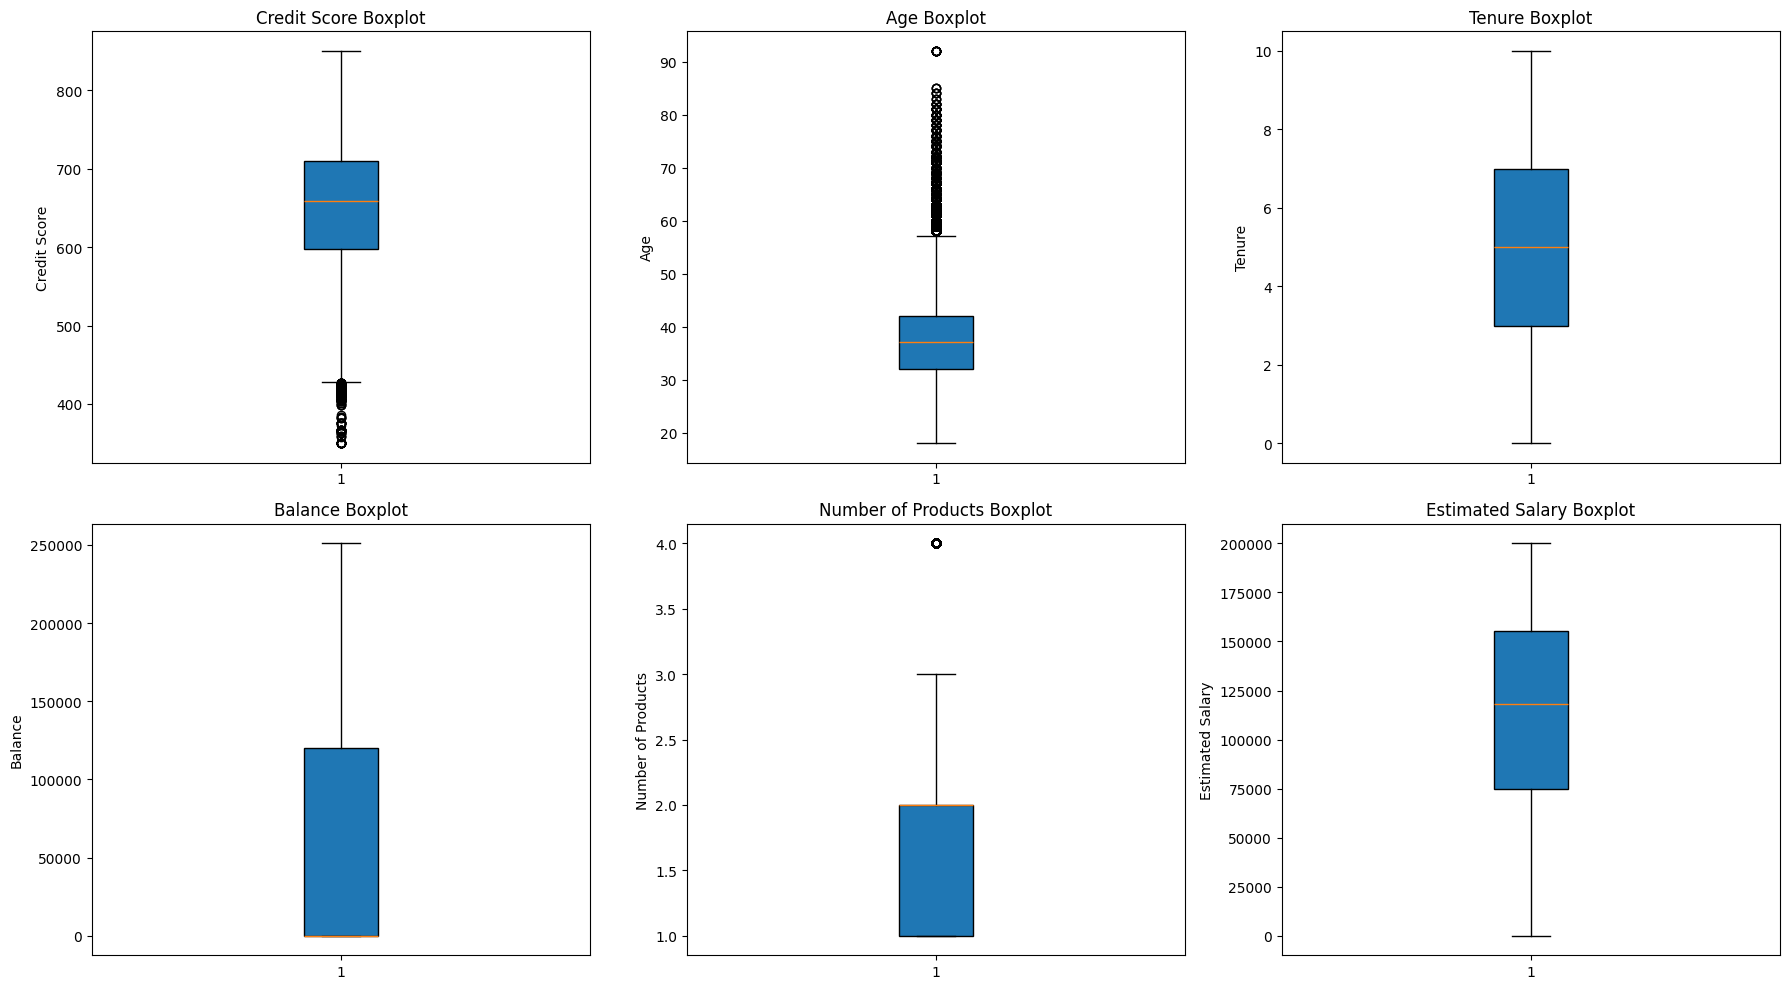

In [18]:
# Create a 2x3 grid of axes
fig, axs = plt.subplots(2, 3, figsize=(18, 10))  # Adjust the figsize to better fit the display

# Plot boxplot for CreditScore
axs[0, 0].boxplot(df['CreditScore'].dropna(), patch_artist=True)  # dropna() removes missing values
axs[0, 0].set_title('Credit Score Boxplot')
axs[0, 0].set_ylabel('Credit Score')

# Plot boxplot for Age
axs[0, 1].boxplot(df['Age'].dropna(), patch_artist=True)
axs[0, 1].set_title('Age Boxplot')
axs[0, 1].set_ylabel('Age')

# Plot boxplot for Tenure
axs[0, 2].boxplot(df['Tenure'].dropna(), patch_artist=True)
axs[0, 2].set_title('Tenure Boxplot')
axs[0, 2].set_ylabel('Tenure')

# Plot boxplot for Balance
axs[1, 0].boxplot(df['Balance'].dropna(), patch_artist=True)
axs[1, 0].set_title('Balance Boxplot')
axs[1, 0].set_ylabel('Balance')

# Plot boxplot for NumOfProducts
axs[1, 1].boxplot(df['NumOfProducts'].dropna(), patch_artist=True)
axs[1, 1].set_title('Number of Products Boxplot')
axs[1, 1].set_ylabel('Number of Products')

# Plot boxplot for EstimatedSalary
axs[1, 2].boxplot(df['EstimatedSalary'].dropna(), patch_artist=True)
axs[1, 2].set_title('Estimated Salary Boxplot')
axs[1, 2].set_ylabel('Estimated Salary')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

From the boxplots above, we can see there are some observations lying out of the IQR range for features `CreditScore`, `Age` and `NumOfProducts`. Since the values in these potential outliers are within reasonable range, it is decided to keep them in the dataset rather than removing. For example, in the boxplot of `CreditScore`, the values of potential outliers are nearly within a range of [320, 420]. A credit score within 300-579 is considered a poor score. Therefore, these values are reasonable and could be important features to predict the probability of the customer exiting the bank or not.

In terms of the `Age` boxplot, the values of potential outliers are roughly within [57, 90]. These may correspond to older individuals, and it is not uncommon to have a wider age range in a general population.

In terms of the `NumOfProducts` boxplot, the value of "4" lies out of the IQR range because very few customers hold 4 kinds of products in the bank. However, this should not be treated as outliers because it is also not due to any data entry error.

### **1.2.4 Check Duplicates**

In [19]:
# Check if there is any duplicated rows
duplicates = df.duplicated()
has_duplicates = duplicates.any()

print("Are there any duplicates?", has_duplicates)

Are there any duplicates? False


## **1.3 Data Transformation and Feature Engineering**

### **1.3.1 Group features by types**

In [20]:
num_col = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
df_num = df[num_col]
cat_col = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
df_cat = df[cat_col]

### **1.3.2 Numerical data: normalization/standardization**

In [21]:
# Convert all numerical columns into float format
df_num = df_num.astype('float')

In [22]:
# Check data types of numerical columns
df_num.dtypes

CreditScore        float64
Age                float64
Tenure             float64
Balance            float64
NumOfProducts      float64
EstimatedSalary    float64
dtype: object

### **1.3.3 Categorical data: one-hot encoding, ordinal encoding**

In [24]:
# Convert ['Geography', 'Gender'] to category format, "HasCrCard", "IsActiveMember" are already encoded
df_cat[['Geography', 'Gender']] = df_cat[['Geography', 'Gender']].astype('category')

In [25]:
df_cat.dtypes

Geography         category
Gender            category
HasCrCard            int64
IsActiveMember       int64
dtype: object

In [26]:
from sklearn.preprocessing import OneHotEncoder

# Transform "Geography" and "Gender" to ohe format
ohe = OneHotEncoder(handle_unknown = 'ignore', dtype=np.int64)

# Fit the variables
ohe.fit(df_cat[['Geography', 'Gender']])

OneHotEncoder(dtype=<class 'numpy.int64'>, handle_unknown='ignore')

In [27]:
# View categories
ohe.categories_

[array(['France', 'Germany', 'Spain'], dtype=object),
 array(['Female', 'Male'], dtype=object)]

In [28]:
# we will relabel these as FeatureName_value to make it self-explainable
new_col_names = []
text_cols = ['Geography', 'Gender']

index = 0

for arr, col_name in zip(ohe.categories_, text_cols):
    for ele in arr[:]: # Skipping the first value label because our OHE model is set to drop the first feature value
        new_col_name = col_name + '_' + ele.strip(' ') 
        new_col_names.append(new_col_name)

# Create dataset of binary features
df_ohe = pd.DataFrame(ohe.transform(df[text_cols]).toarray(), columns=new_col_names)
print(df_ohe.shape)

(165034, 5)


In [29]:
# View "df_ohe"
df_ohe

,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,1,0,0,0,1
1,1,0,0,0,1
2,1,0,0,0,1
3,1,0,0,0,1
4,0,0,1,0,1
...,...,...,...,...,...
165029,0,0,1,1,0
165030,1,0,0,0,1
165031,1,0,0,0,1
165032,0,0,1,1,0


### **1.3.4 Concatenate numerical features and encoded categorical features and create training and testing data** 

In [30]:
# Finalize feature matrix and target variable, and create train-test split
df_X = pd.concat([df_num, df_ohe, df[['HasCrCard', 'IsActiveMember']]], axis=1)

# Print df_X to view
df_X

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard,IsActiveMember
0,668.0,33.0,3.0,0.00,2.0,181449.97,1,0,0,0,1,1,0
1,627.0,33.0,1.0,0.00,2.0,49503.50,1,0,0,0,1,1,1
2,678.0,40.0,10.0,0.00,2.0,184866.69,1,0,0,0,1,1,0
3,581.0,34.0,2.0,148882.54,1.0,84560.88,1,0,0,0,1,1,1
4,716.0,33.0,5.0,0.00,2.0,15068.83,0,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,667.0,33.0,2.0,0.00,1.0,131834.75,0,0,1,1,0,1,1
165030,792.0,35.0,3.0,0.00,1.0,131834.45,1,0,0,0,1,0,0
165031,565.0,31.0,5.0,0.00,1.0,127429.56,1,0,0,0,1,1,1
165032,554.0,30.0,7.0,161533.00,1.0,71173.03,0,0,1,1,0,0,1


In [31]:
# Create target variable
target = 'Exited'
df_y = df[[target]]
df_y.shape

(165034, 1)

## **1.4 Statistical Summary**

### **1.4.1 Basic statistics (mean, median, mode)**

In [32]:
# Check summary statistics on the numerical columns of the original data frame
# before normalization
round(df[num_col].describe(), 2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
count,165034.00,165034.00,165034.00,165034.00,165034.00,165034.00
mean,656.45,38.13,5.02,55478.09,1.55,112574.82
std,80.10,8.87,2.81,62817.66,0.55,50292.87
min,350.00,18.00,0.00,0.00,1.00,11.58
25%,597.00,32.00,3.00,0.00,1.00,74637.57
50%,659.00,37.00,5.00,0.00,2.00,117948.00
75%,710.00,42.00,7.00,119939.52,2.00,155152.47
max,850.00,92.00,10.00,250898.09,4.00,199992.48


All the values in the summary statistics seems reasonable. One interesting point from the table is that most of the account has a balance of zero.

### **1.4.2 Visualization (scatter plot, histograms, boxplot, heatmap, etc)**

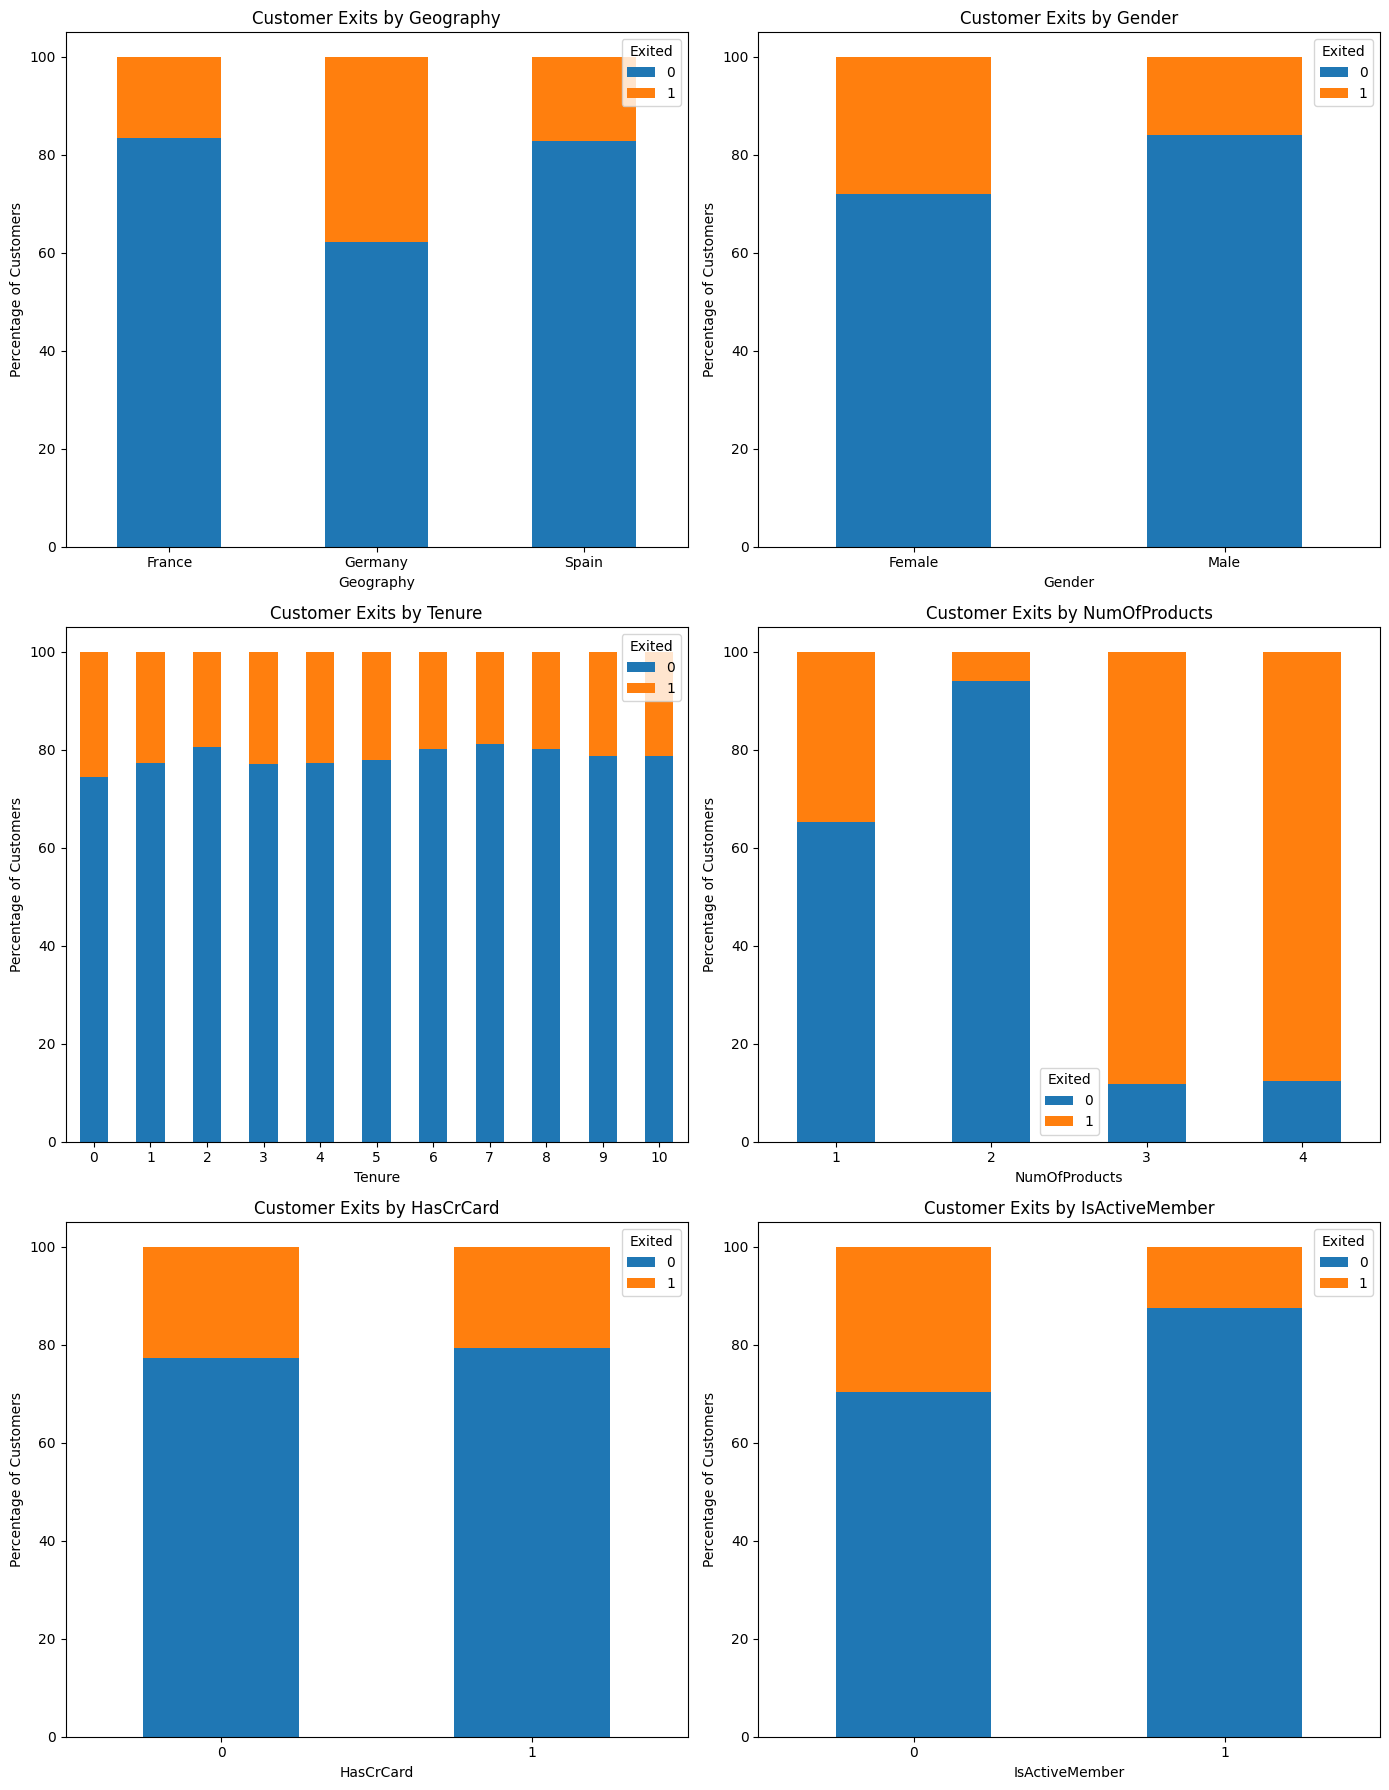

In [33]:
# Set figure size
plt.figure(figsize=(14, 18))

# Define the categories for plotting
categories = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

# Loop through each category to plot
for i, category in enumerate(categories):
    plt.subplot(3, 2, i+1)  # Creating a subplot for each category
    
    # Calculating the proportion of each category by 'Exited' status
    data = df.groupby([category])['Exited'].value_counts(normalize=True).unstack().fillna(0) * 100
    
    # Plotting stacked bars
    data.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title(f'Customer Exits by {category}')
    plt.xlabel(category)
    plt.ylabel('Percentage of Customers')
    plt.xticks(rotation=0)

plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()


From the above stack plots, several observations are noted:

1) The exit rate in Germany is notably higher than in France and Spain;
2) The exit rate in female customers is higher than for male customers;
3) Different years of tenures and whether the customer has credit card or not seem unimportant to the exit rate.
4) Counterintuitively, customers who hold 3 or 4 products in the bank are more likely to exit the bank, while customers who hold 2 products in the bank tend to have to lowest exit rate;
5) Customers who are active members are more likely to stay in the bank.

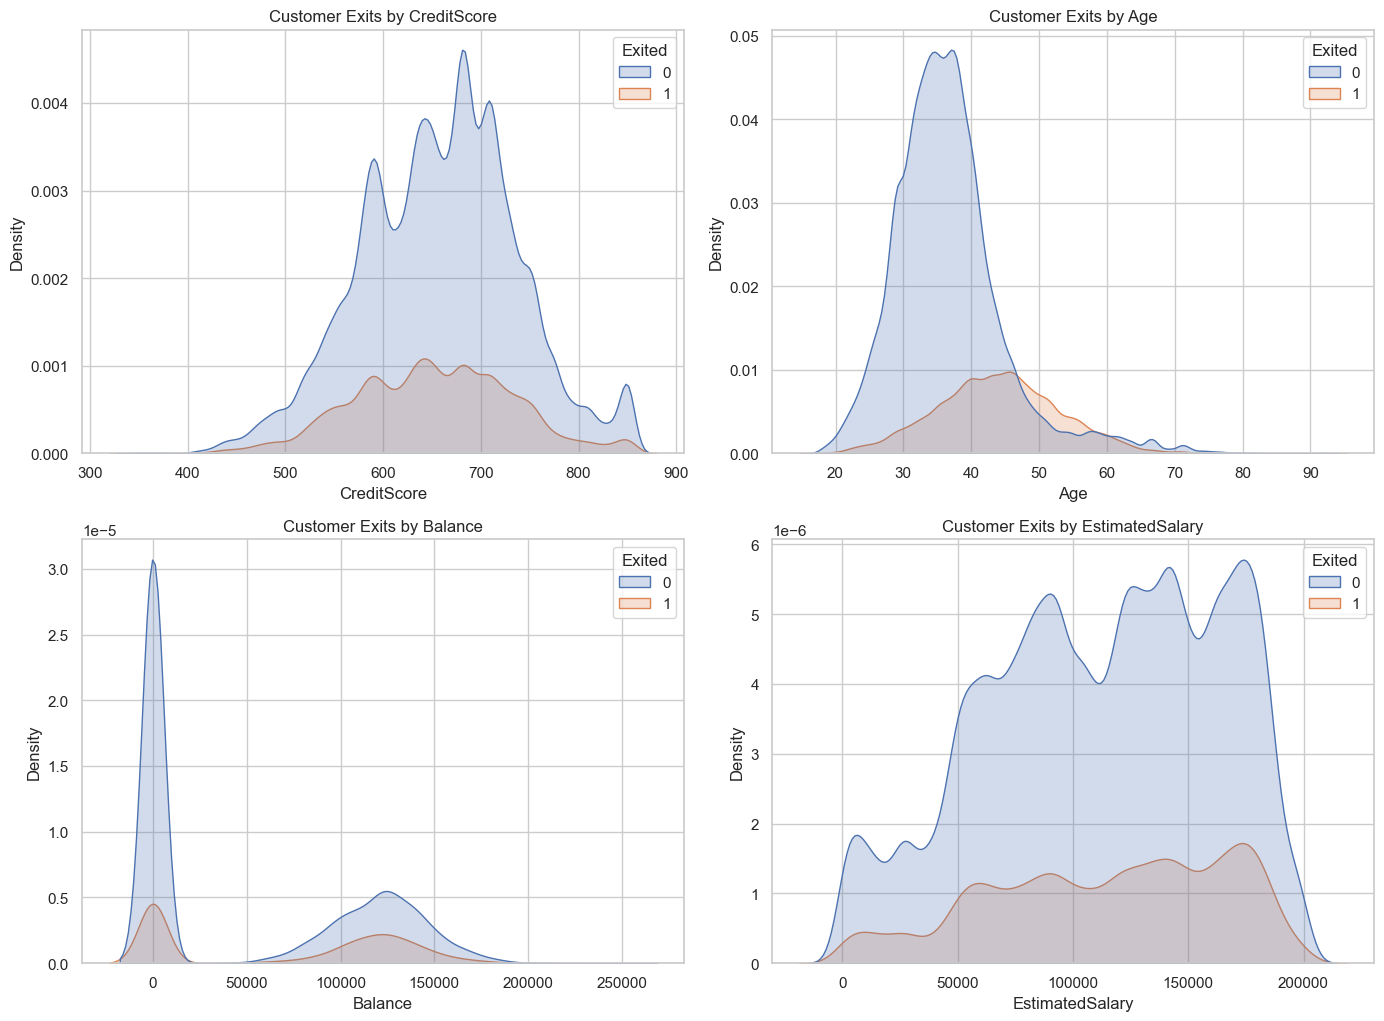

In [34]:
sns.set(style="whitegrid")

variables = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
n_rows = 3  
n_cols = 2  

plt.figure(figsize=(14, 15))

for i, variable in enumerate(variables):
    plt.subplot(n_rows, n_cols, i+1) 
    sns.kdeplot(data=df, x=variable, hue="Exited", fill=True)
    plt.title(f'Customer Exits by {variable}')
    plt.xlabel(f'{variable}')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

One interesting observation from the above density plots is that customers aged between 47 and 58 are more likely to churn. The number of customers within this age range who churned exceeds the number of customers who did not churn.

### **1.4.3 Check data distribution and skewness**

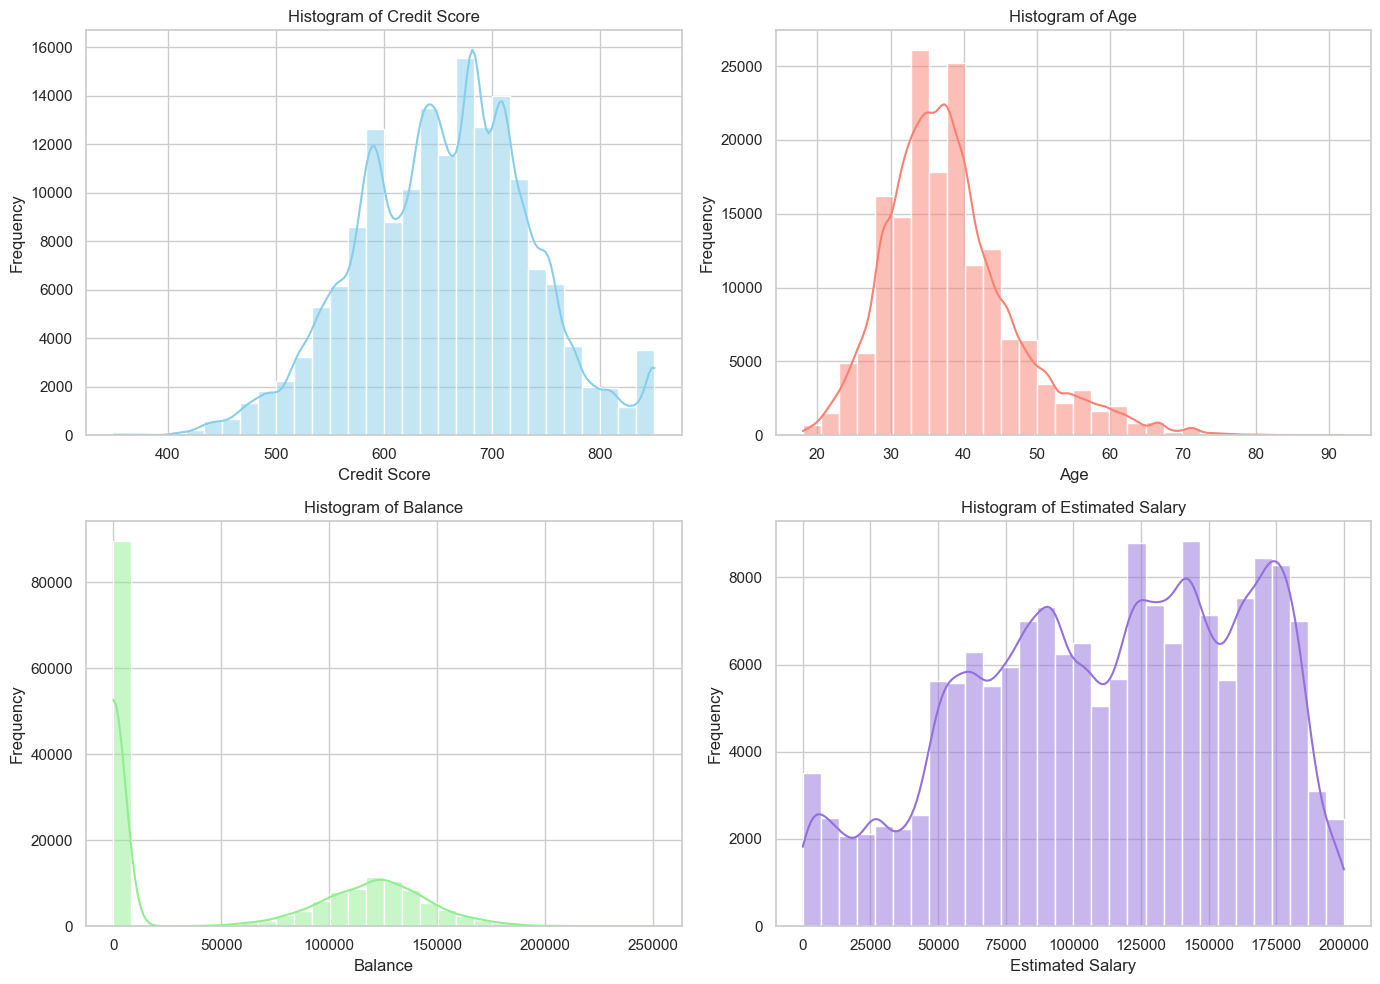

In [35]:
plt.figure(figsize=(14, 10))

# CreditScore
plt.subplot(2, 2, 1)
sns.histplot(df['CreditScore'], bins=30, kde=True, color='skyblue')
plt.title('Histogram of Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')

# Age
plt.subplot(2, 2, 2)
sns.histplot(df['Age'], bins=30, kde=True, color='salmon')
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Balance
plt.subplot(2, 2, 3)
sns.histplot(df['Balance'], bins=30, kde=True, color='lightgreen')
plt.title('Histogram of Balance')
plt.xlabel('Balance')
plt.ylabel('Frequency')

# EstimatedSalary
plt.subplot(2, 2, 4)
sns.histplot(df['EstimatedSalary'], bins=30, kde=True, color='mediumpurple')
plt.title('Histogram of Estimated Salary')
plt.xlabel('Estimated Salary')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The distribution of credit score is fairly normal. The distribution of age is a bit right-skewed. In terms of balance, as observed before, a high percentage of the observations are 0. The distribution of balance without zeros seem quite normal. Finally, no obvious skewness is found in the distribution of estimated salary.

## **1.5 Correlation Analysis**

In [36]:
df_X.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'EstimatedSalary', 'Geography_France', 'Geography_Germany',
       'Geography_Spain', 'Gender_Female', 'Gender_Male', 'HasCrCard',
       'IsActiveMember'],
      dtype='object')

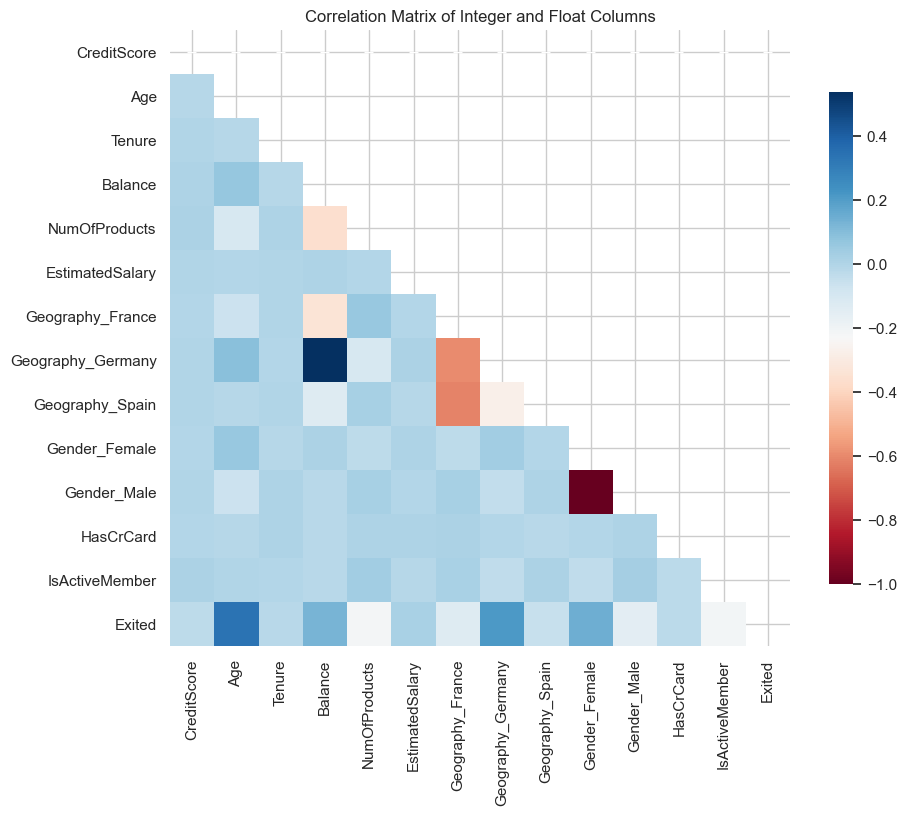

In [39]:
# Create useful columns
numeric_cols = pd.concat([df_X, df_y], axis=1)

# Calculate correlation matrix
corr_matrix = numeric_cols.corr()

# Create a mask to only show the lower part
mask = np.triu(corr_matrix)

# Plot the heatmap of correlation matrix and apply the mask
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='RdBu', cbar_kws={'shrink': .8})
plt.title('Correlation Matrix of Integer and Float Columns')
plt.show()


There are several points noticeable from the above heatmap:

- Counterintuitively, the number of products and balance in a bank account is negatively correlated and the correlation coefficient is -0.36.

- Customers located in France and Spain are negatively correlated with their balance, with France being more negative.

- Customers located in Germany are positively correlated with balance and are also slightly positively correlated with age.

- **"Age (0.34), location in Germany (0.21), gender being female (0.15), balance (0.13)"** are the **top 4 positive factors** correlated with a customer churning out of the bank. The positive correlation between balance and churning is counterintuitive.

- **"Number of products (-0.21), being an active member (-0.21), gender being male (-0.15), location in France (-0.13)"** are the **top 4 negative factors** correlated with a customer churning out of the bank.

# **2. Data Split & Normalization**

In [40]:
# Split data into train/test set
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size = 0.3, 
                                                                random_state = 42)

# Reset index
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Examine train and test set shape
X_train.shape, X_test.shape

((115523, 13), (49511, 13))

In [41]:
# Normalize numerical data
scaler = StandardScaler()
X_train[num_col] = pd.DataFrame(scaler.fit_transform(X_train[num_col]), columns=X_train[num_col].columns)
X_test[num_col] = pd.DataFrame(scaler.fit_transform(X_test[num_col]), columns=X_test[num_col].columns)
X_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard,IsActiveMember
0,-1.659577,0.774369,0.347345,-0.886492,0.814577,0.400924,0,0,1,0,1,1,0
1,-0.472997,0.436240,-0.008887,0.616653,-1.011767,1.622032,0,0,1,1,0,0,1
2,1.887673,-0.578146,-0.008887,0.760199,0.814577,0.024038,1,0,0,0,1,1,0
3,-1.434751,-1.592533,1.059810,-0.886492,0.814577,0.352814,1,0,0,1,0,0,0
4,-0.885177,0.436240,1.416042,0.846057,-1.011767,0.203345,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115518,0.139029,0.774369,0.347345,0.777060,-1.011767,0.007606,0,1,0,0,1,1,0
115519,1.175725,0.548950,0.703578,-0.886492,0.814577,-0.473888,1,0,0,0,1,1,0
115520,1.200706,0.098111,0.703578,-0.886492,0.814577,1.099090,1,0,0,1,0,1,0
115521,0.351364,1.112498,-0.365119,-0.886492,0.814577,-1.743840,1,0,0,1,0,1,1


# **3. Handling Data Imbalance: Down-sampling**

As seen from EDA, only roughly 20% of observations are labeled as positive for target variable. Therefore, there is an imbalanced problem. We need to handle this problem first before estimating any models. Here, down-sampling method is used because it is easier to implement and easily understood. The balanced dataset is still large enough even after down-sampled.

In [42]:
def downsampling(X_train, y_train):
    # Concatenate the features and target of the training data
    train_data = pd.concat([X_train, y_train], axis=1)

    # Separate the samples that exited and not exited the bank
    majority_class = train_data[train_data['Exited'] == 0]
    minority_class = train_data[train_data['Exited'] == 1]

    # Conduct down-sampling
    majority_downsampled = majority_class.sample(n=len(minority_class), random_state=42)  # 使数量与少数类相同

    # Re-concatenate the training data after applying down-sampling
    balanced_train_data = pd.concat([majority_downsampled, minority_class]).reset_index(drop=True)

    # Separate the features and target in the down-sampled data
    X_train_balanced = balanced_train_data.drop('Exited', axis=1)
    y_train_balanced = balanced_train_data[['Exited']]

    # Return the balanced training data
    return X_train_balanced, y_train_balanced

In [43]:
X_train_balanced, y_train_balanced = downsampling(X_train, y_train)
X_train_balanced

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard,IsActiveMember
0,1.138254,-0.916275,-0.008887,-0.886492,-1.011767,-0.061101,1,0,0,0,1,0,1
1,-0.185719,-1.254404,-0.721352,-0.886492,0.814577,-1.200160,1,0,0,1,0,1,1
2,0.076577,-0.352727,0.703578,-0.886492,0.814577,0.948256,1,0,0,0,1,1,0
3,0.613661,2.126884,-0.008887,1.687372,0.814577,1.219555,0,1,0,1,0,0,1
4,-2.059267,0.548950,0.347345,-0.886492,0.814577,-0.333299,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49081,-0.935138,-1.254404,1.059810,-0.886492,-1.011767,-2.000394,1,0,0,1,0,1,0
49082,-0.760274,0.436240,1.059810,0.249841,-1.011767,-0.576966,0,1,0,1,0,1,0
49083,-2.296583,0.210821,-1.433816,0.827314,-1.011767,-1.080048,1,0,0,1,0,0,0
49084,0.738564,-0.014598,-0.365119,0.740629,-1.011767,1.631809,0,1,0,1,0,1,0


# **4. Supervised Learning & Parameter Tuning**

To address the challenge of predicting customer churn, I considered both the complexity of the data and the models. The dataset features a mix of continuous and categorical variables, including 'CreditScore' (a continuous variable), 'Geography' (a categorical variable with three unique values), and 'NumOfProducts' (a categorical variable with four unique values). Given this variety, it was essential to choose models that can handle both types of data effectively. Given these information, logistic regression, KNN, and random forest are chosen. A final model is constructed using stacking technique to combine the prediction of three models to achieve a better model  performance.  

The decision to use these models and the stacking technique was driven by the need for a versatile and powerful approach that maximizes the predictive strength of our diverse data features, leading to more accurate churn predictions.

## **4.1 Logistic Regression**

I started with logistic regression because it's a robust baseline model that performs well with binary classification tasks like churn prediction. It is particularly effective at understanding the relationship between the target variable and various predictor variables, and it offers good interpretability of feature importance.

### **4.1.1 Default Logistic Regression:**

In [436]:
# Fit a logistic regression model by default parameters as a baseline
lr_default = LogisticRegression(random_state=42).fit(X_train_balanced, y_train_balanced)

# Calculate roc_auc score
auc_scores = cross_val_score(lr_default, X_train_balanced, y_train_balanced, cv=5, scoring='roc_auc')

# Print score of every fold and average score
print("AUC Scores per fold: ", auc_scores)
print(f"Average AUC Score: ", round(auc_scores.mean(),6))

AUC Scores per fold:  [0.81547555 0.81647754 0.82334449 0.82337072 0.81552748]
Average AUC Score:  0.818839


In a logistic regression with default parameters, using cross-validation, we have an average AUC score of 0.818839. AUC score is selected because in this context, we care about the model performance using different thresholds.

### **4.1.2 Define a GridSearchCV Function to Improve Code Efficiency:**

In [432]:
def perform_grid_search(model, param_grid, X_train, y_train, scoring_metric, cv_folds):
    
    # Generate a GridSearchCV object
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring_metric, cv=cv_folds, verbose=2, n_jobs=-1)
    
    # Fit GridSearchCV on training data
    grid_search.fit(X_train, y_train)
    
    # Print best model score
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {grid_search.best_score_:.6f}")
    
    return grid_search


### **4.1.3 Implement GridSearchCV in Logistic Regression:**

In [437]:
# Define logistic regression model
lr = LogisticRegression(random_state=42)

# Define a parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['lbfgs', 'liblinear'] # 6*2*2 = 24 combinations --> 24*5 = 120 fits
}

# Perform GridSearchCV to tune parameters
perform_grid_search(lr, param_grid, X_train_balanced, y_train_balanced, 'roc_auc', 5)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.818975


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='roc_auc', verbose=2)

The above code chooses different values of `C`, `penalty`, and `solver` to find the optimal combination of hyperparameters for the logistic regression model. These are chosen because they significantly impact model performance. `C` controls regularization strength, `penalty` specifies the regularization norm (`l1` or `l2`), and `solver` determines the optimization algorithm. The best parameters found are `{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}`, improving performance to 0.818975, up from 0.818839 for the default logistic regression model. This fine-tuning leads to a slight but meaningful performance improvement.

### **4.1.4 Importance of Features:**

In [438]:
# Extract column names of X_train_balanced 
feature_names = X_train_balanced.columns

# Fit the logistic regression with optimal hyper-parameters
lr_opt = LogisticRegression(random_state=42, C=0.01, penalty='l2', solver='liblinear')

# Train the model
lr_opt.fit(X_train_balanced, y_train_balanced)

LogisticRegression(C=0.01, random_state=42, solver='liblinear')

In [439]:
# Obtain the coefficients 
coefficients = lr_opt.coef_[0]

# Organize into a DataFrame
coef_df = pd.DataFrame(data={'Feature': feature_names, 'Coefficient': coefficients})
print(coef_df.sort_values(by='Coefficient', ascending=False))

              Feature  Coefficient
1                 Age     0.853466
7   Geography_Germany     0.739883
9       Gender_Female     0.452885
5     EstimatedSalary     0.019781
3             Balance    -0.013605
2              Tenure    -0.043739
0         CreditScore    -0.064401
10        Gender_Male    -0.192878
11          HasCrCard    -0.220455
8     Geography_Spain    -0.229441
6    Geography_France    -0.250436
4       NumOfProducts    -0.391997
12     IsActiveMember    -1.139467


Generally, the top 4 positive and top 4 negative features are generally consistent with the following observations from the correlation matrix. Noticeably, the counterintuition of positive correlation between balance and churning out is not seen from the result here.

Some observations from correlation matrix:

- **"Age (0.34), location in Germany (0.21), gender being female (0.15), balance (0.13)"** are the **top 4 positive factors** correlated with a customer churning out of the bank. The positive correlation between balance and churning is counterintuitive.

- **"Number of products (-0.21), being an active member (-0.21), gender being male (-0.15), location in France (-0.13)"** are the **top 4 negative factors** correlated with a customer churning out of the bank.

## **4.2 K-Nearest-Neighbors (KNN)**

I also utilized KNN to incorporate the aspect of similarity between cases. KNN is a non-parametric method that works well for classification by measuring the distance between points. It's useful in our context because it can naturally handle multi-modal data distributions and can make predictions based on the closest historical points.

### **4.2.1 Default KNN:**

In [440]:
# Construct a KNN model
knn_default = KNeighborsClassifier()

# Train and fit the model
knn_default.fit(X_train_balanced, y_train_balanced)

# Use cross-validation to evaluate the model
cv_scores = cross_val_score(knn_default, X_train_balanced, y_train_balanced, cv=5, scoring='roc_auc', n_jobs=-1)

print(f"ROC-AUC Scores: {cv_scores}")
print(f"Mean ROC-AUC Score: {cv_scores.mean():.6f}")

ROC-AUC Scores: [0.83924297 0.83951312 0.84768141 0.84133462 0.84071408]
Mean ROC-AUC Score: 0.841697


In this default KNN model, we get a roc_auc score of 0.841697. There is an improvement of around 2.27% from the optimal logistic regression.

### **4.2.2 Implement GridSearchCV:**

In [441]:
# Construct a KNN model
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean'],
    'p': [1, 2]
}

# Perform GridSearchCV to tune parameters
perform_grid_search(knn, param_grid, X_train_balanced, y_train_balanced, 'roc_auc', 5)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'metric': 'euclidean', 'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}
Best score: 0.869071
Execution time: 144.70 seconds


The above code chooses `n_neighbors`, `weights`, `metric`, and `p` to find the optimal combination of hyperparameters for the KNN model. These are chosen because they critically affect the model's performance. `n_neighbors` determines the number of nearest neighbors to consider, `weights` decides how to weight the neighbors' votes, `metric` defines the distance metric used, and `p` specifies the power parameter for the Minkowski metric. The optimal hyperparameters found are `{'metric': 'euclidean', 'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}`, improving the KNN model's performance from 0.841697 to 0.869071, an increase of approximately 2.74%.

### **4.2.3 Fit Optimal KNN:**

In [451]:
# Construct a KNN model
knn_opt = KNeighborsClassifier(metric='euclidean', n_neighbors=15, p=1, weights='uniform')

# Train and fit the model
knn_opt.fit(X_train_balanced, y_train_balanced)

KNeighborsClassifier(metric='euclidean', n_neighbors=15, p=1)

### **4.2.4 Importance of Features**

In [452]:
# Extract column names in X_train_balanced
features = X_train_balanced.columns
baseline_scores = cross_val_score(knn_opt, X_train_balanced, y_train_balanced, cv=5, scoring='roc_auc')
baseline_mean = np.mean(baseline_scores)

importances = {}

for feature in features:
    X_temp = X_train_balanced.drop(feature, axis=1)
    scores = cross_val_score(knn_opt, X_temp, y_train_balanced, cv=5, scoring='roc_auc')
    mean_score = np.mean(scores)
    importances[feature] = baseline_mean - mean_score

# Print importance of each feature
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_importances:
    print(f"Importance of {feature}: {round(importance, 6)}")

Importance of NumOfProducts: 0.071214
Importance of Age: 0.043373
Importance of IsActiveMember: 0.014329
Importance of Balance: 0.008859
Importance of Geography_Germany: 4e-06
Importance of HasCrCard: -0.00068
Importance of Geography_France: -0.000781
Importance of Geography_Spain: -0.000833
Importance of Gender_Female: -0.00108
Importance of Gender_Male: -0.00108
Importance of Tenure: -0.00119
Importance of EstimatedSalary: -0.001314
Importance of CreditScore: -0.002054


Generally, the importance of features aligns with what we see in logistic regression model, as we can observe from the positive importance of `NumOfProducts`, `Age`, `IsActiveMember`, `Balance`, except that the geography does not matter as much in KNN as in logistic regression.

This could be due to the fact that in distance-based models like KNN, continuous features that exhibit a wide range of values can influence the model more than binary features. This is because changes in binary features often don't offer as nuanced a difference in distances as continuous features do.

## **4.3 Random Forest**

Furthermore, I included a random forest model due to its proficiency in handling large data sets with higher dimensionality. It's capable of modeling non-linear relationships due to its ensemble nature, aggregating multiple decision trees to reduce overfitting and improve prediction accuracy.

### **4.3.1 Default Random Forest:**

In [446]:
rf_default = RandomForestClassifier(random_state = 42).fit(X_train_balanced, y_train_balanced)

# Calculate roc_auc score
rf_auc_scores = cross_val_score(rf_default, X_train_balanced, y_train_balanced, cv=5, scoring='roc_auc')

# Print score of every fold and average score
print("AUC Scores per fold: ", rf_auc_scores)
print("Average AUC Score: ", rf_auc_scores.mean())

AUC Scores per fold:  [0.87242677 0.86970695 0.8783888  0.87176257 0.87137363]
Average AUC Score:  0.8727317434602095


A **random forest model even further outperforms the optimal KNN model** we saw above! The score goes up from 0.86097 to 0.872732, a 1.18% increase.

### **4.3.2 Implement GridSearchCV:**

In [447]:
# Start a timer
start_time = time.time()

# Define the random forest model
rf = RandomForestClassifier(random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']  # 2*2*2*2*1 = 16 combinations --> 80 fits
}

# Implement GridSearchCV to tune parameters
perform_grid_search(rf, param_grid, X_train_balanced, y_train_balanced, 'roc_auc', 5)

# Timer ends
end_time = time.time()

# Calculate and print running time
elapsed_time = end_time - start_time
print("Execution time: {:.2f} seconds".format(elapsed_time))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best score: 0.884885
Execution time: 391.28 seconds


`n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, and `max_features` are selected for parameter tuning because they significantly influence the performance of a Random Forest model. `n_estimators` determines the number of trees, `max_depth` sets the maximum depth of each tree, `min_samples_split` and `min_samples_leaf` control the minimum samples required for splitting a node and being a leaf node, respectively, and `max_features` specifies the number of features to consider when looking for the best split. GridSearchCV identifies the optimal parameters as `{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}`. Using these parameters, the cross-validation score (AUC-ROC) improves from 0.8727 (default random forest model) to 0.8849, a further 1.22% increase.

### **4.3.3 Importance of Features:**

                   importance
NumOfProducts        0.324757
Age                  0.315020
IsActiveMember       0.097570
Balance              0.070748
Geography_Germany    0.046651
EstimatedSalary      0.029082
CreditScore          0.028459
Gender_Female        0.021799
Gender_Male          0.021276
Geography_France     0.017235
Tenure               0.015031
Geography_Spain      0.007488
HasCrCard            0.004883


<Figure size 1200x800 with 0 Axes>

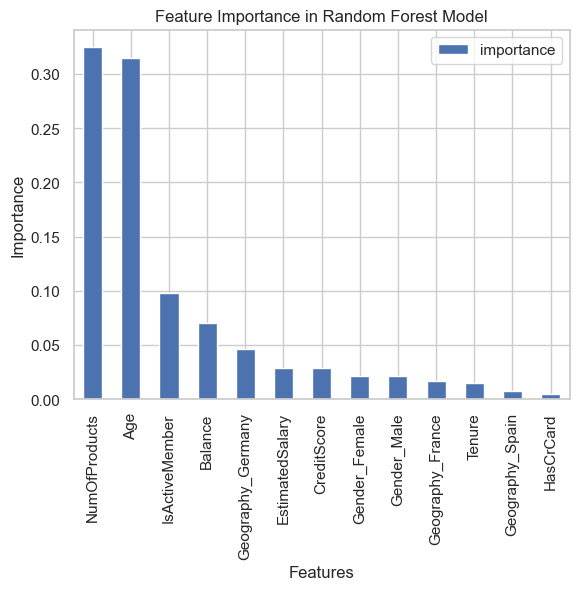

In [448]:
# Fit the optimal random forest model
rf_opt = RandomForestClassifier(random_state=42, max_depth=10, max_features='sqrt', 
                                min_samples_leaf=1, min_samples_split=5, n_estimators=100)
rf_opt.fit(X_train_balanced, y_train_balanced)

# Obtain importance of each feature
feature_importances = pd.DataFrame(rf_opt.feature_importances_,
                                   index = X_train_balanced.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

# Print it
print(feature_importances)

# Visualize it
plt.figure(figsize=(12, 8))
feature_importances.plot(kind='bar')
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

As seen in the above bar plot, the most important features in the random forest model are `NumOfProducts`, `Age`, `IsActiveMember`, `Balance`, `Geography_Germany`. These top 4 features are exactly the same as in KNN model.

## **4.4 Stacking**

Given the diversity of models and their individual strengths, I opted for a **stacking model** to improve their predictive capabilities. By combining logistic regression, KNN, and random forest, the stacking approach leverages the unique strengths of each. The meta-model, which integrates the outputs from each base model, provides a refined final prediction. This ensemble method not only increases the robustness of the prediction by reducing variance and bias but also tends to outperform individual models, particularly in complex datasets like ours.

### **Define the base learners and find the optimal final estimator among _LogisticRegression_, _RandomForestClassifier_, _SVC_, and _GradientBoostingClassifier_.**

In [449]:
# Define 3 base learners
base_estimators = [
    ('lr', LogisticRegression(random_state=42, C=0.01, penalty='l2', solver='liblinear')),
    ('rf', RandomForestClassifier(random_state=42, max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, n_estimators=100)),
    ('knn', KNeighborsClassifier(metric='euclidean', n_neighbors=15, p=1, weights='uniform'))
]

In [450]:
# Set different final estimators
param_grid = {
    'final_estimator': [LogisticRegression(), RandomForestClassifier(), SVC(), GradientBoostingClassifier()]
}

# Generate a stacking model
stack_clf = StackingClassifier(estimators=base_estimators, cv=5)

# Implement GridSearchCV to choose the best final estimator
perform_grid_search(stack_clf, param_grid, X_train_balanced, y_train_balanced, 'roc_auc', 5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'final_estimator': LogisticRegression()}
Best score: 0.885327


GridSearchCV(cv=5,
             estimator=StackingClassifier(cv=5,
                                          estimators=[('lr',
                                                       LogisticRegression(C=0.01,
                                                                          random_state=42,
                                                                          solver='liblinear')),
                                                      ('rf',
                                                       RandomForestClassifier(max_depth=10,
                                                                              min_samples_split=5,
                                                                              random_state=42)),
                                                      ('knn',
                                                       KNeighborsClassifier(metric='euclidean',
                                                                            n_neighbors=15,
                                                                            p=1))]),
             n_jobs=-1,
             param_grid={'final_estimator': [LogisticRegression(),
                                             RandomForestClassifier(), SVC(),
                                             GradientBoostingClassifier()]},
             scoring='roc_auc', verbose=2)

By combining the outputs of the three models in a stacking model, the final performance increases from 0.8849 (optimal random forest model) to 0.8853, a 0.4% improvement. This modest increase **demonstrates that integrating logistic regression, KNN, and random forest models in a stacking ensemble can further enhance performance**. While the improvement is small, it indicates that the complementary strengths of different models can lead to a more robust and accurate predictive model. Stacking leverages the diverse learning capabilities of each base model, thus refining the overall predictive power.

# **5. Unsupervised Learning**

## **5.1 K-means Clustering**

In [44]:
# Choose K using Elbow Method
def plot_elbow(X):
    
    K_range = range(1, 16)
    WCSS = []

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        WCSS.append(kmeans.inertia_)  # use inertia_ to evaluate each k

    # Plot WCSS graph
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, WCSS, 'bo-')
    plt.xlabel('Number of clusters K')
    plt.ylabel('WCSS')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

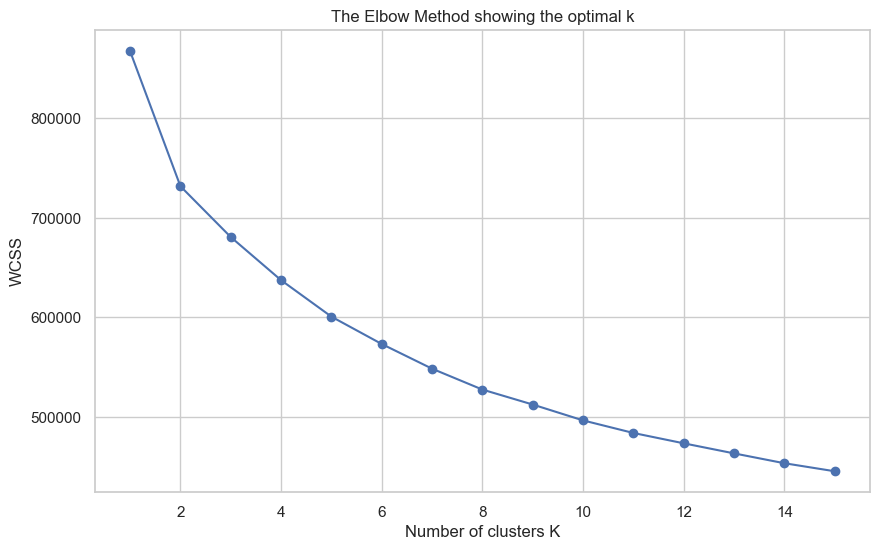

In [45]:
plot_elbow(X_train)

The above graph shows the WCSS value for different values of K. As seen from the graph, the loss value decreases as K increases. However, there is not a distinct elbow point. We need to conduct further investigation into the optimal K. The following uses different values of K to test which improve the performance of the supervised model.

### **5.1.1 Refit Optimal Supervised Model with Clustering Features:**

In [51]:
# Define base learners
base_estimators = [
    ('lr', LogisticRegression(random_state=42, C=0.01, penalty='l2', solver='liblinear')),
    ('rf', RandomForestClassifier(random_state=42, max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, n_estimators=100)),
    ('knn', KNeighborsClassifier(metric='euclidean', n_neighbors=15, p=1, weights='uniform'))
]

# Define the final learner
final_estimator = LogisticRegression()

In [ ]:
# Iterate through different values of k
for k in range(2, 8):
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    # Add clustering result into training and testing data
    X_train['Cluster'] = kmeans.fit_predict(X_train)
    X_test['Cluster'] = kmeans.predict(X_test)

    # Apply downsampling
    X_train_balanced_unsup, y_train_balanced_unsup = downsampling(X_train, y_train)

    # Construct and fit a stacking model
    stack_clf = StackingClassifier(estimators=base_estimators, final_estimator=final_estimator, cv=5)
    stack_clf.fit(X_train_balanced_unsup, y_train_balanced_unsup)

    # Calculate roc_auc score
    auc_scores = cross_val_score(stack_clf, X_train_balanced_unsup, y_train_balanced_unsup, cv=5, scoring='roc_auc')

    # Print score of every fold and average score
    print(f"AUC Scores for k={k}: ", auc_scores)
    print("Average AUC Score: ", auc_scores.mean())

    # Remove 'Cluster' for the next iteration
    X_train.drop(columns='Cluster', inplace=True)
    X_test.drop(columns='Cluster', inplace=True)

AUC Scores for k=2:  [0.88461559 0.88370914 0.89018714 0.88298027 0.88345039]
Average AUC Score:  0.884988505735784
AUC Scores for k=3:  [0.88445786 0.88374259 0.89036093 0.88375317 0.88267724]
Average AUC Score:  0.8849983571944516
AUC Scores for k=4:  [0.88434055 0.88335605 0.89087044 0.88357055 0.88339308]
Average AUC Score:  0.8851061343530912
AUC Scores for k=5:  [0.88385528 0.88380257 0.88997551 0.8835063  0.8831037 ]
Average AUC Score:  0.8848486725262887
AUC Scores for k=6:  [0.88435366 0.88399498 0.89050607 0.88351722 0.88334709]
Average AUC Score:  0.8851438039298399
AUC Scores for k=7:  [0.88412767 0.88302995 0.89048125 0.88278208 0.88353278]
Average AUC Score:  0.8847907450835392


It can be seen that after **incorporating the results of K-means clustering, the model performance deteriorated**. None of the models outperformed the original model's performance of 0.8853. This indicates that the clustering results did not enhance the model's ability to distinguish between customers who churn and those who do not. This suggests that either the clustering approach or the resulting features were not well-aligned with the churn prediction task.

## **5.2 PCA**

In [46]:
# First: Set n_components to 10 (a relatively large number) to see how many PCs do we need
pca = PCA(n_components=10)
pca.fit(X_train)

pca.explained_variance_ratio_

array([0.19288516, 0.13429775, 0.13339389, 0.13258691, 0.12864354,
       0.0921613 , 0.06502088, 0.04328969, 0.03324518, 0.02467257])

In [47]:
# Second: calculate cumulated sum of explained variance
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Third: find the number of PCs needed to explain as least 90% of total variance
n_components = np.where(cumulative_variance_ratio >= 0.9)[0][0] + 1

# Print the number of PCs needed
print("Number of components to explain 90% of variance:", n_components)

Number of components to explain 90% of variance: 8


8 PCs are enough to catch over 90% of the variance in the original data.

In [48]:
# Fourth: apply PCA
pca = PCA(n_components=n_components)
X_pca = pd.DataFrame(pca.fit_transform(X_train)).rename(columns={0:'PC1', 1:'PC2', 2:'PC3', 3:'PC4', 4:'PC5', 5:'PC6', 6:'PC7', 7:'PC8'})
X_test_pca = pd.DataFrame(pca.transform(X_test)).rename(columns={0:'PC1', 1:'PC2', 2:'PC3', 3:'PC4', 4:'PC5', 5:'PC6', 6:'PC7', 7:'PC8'})

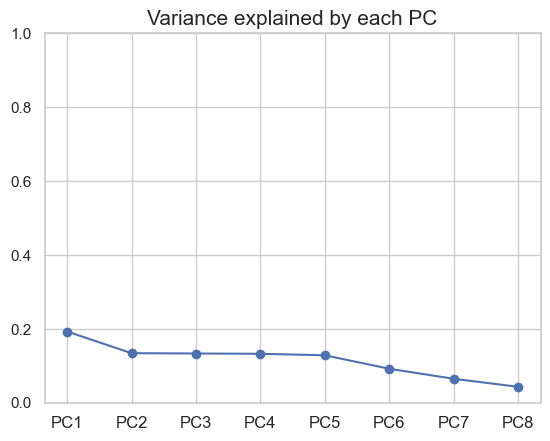

In [49]:
# Plot the proportion explained by each PC
plt.plot(pca.explained_variance_ratio_, 'o-')
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'], fontsize=12)
plt.ylim(0, 1)  
plt.title('Variance explained by each PC', fontsize=15);

The graph above illustrates the percentage of variance explained by each principal component (PC). The relatively flat line indicates that the top 8 PCs explain nearly the same proportion of variance. This suggests that the dataset's variance is distributed fairly evenly across these principal components, indicating that no single component dominates in explaining the data's variability. Consequently, it implies that multiple dimensions contribute similarly to the dataset's structure, and a significant dimensionality reduction might not be achievable without considerable loss of information.

### **PCA Visualization**

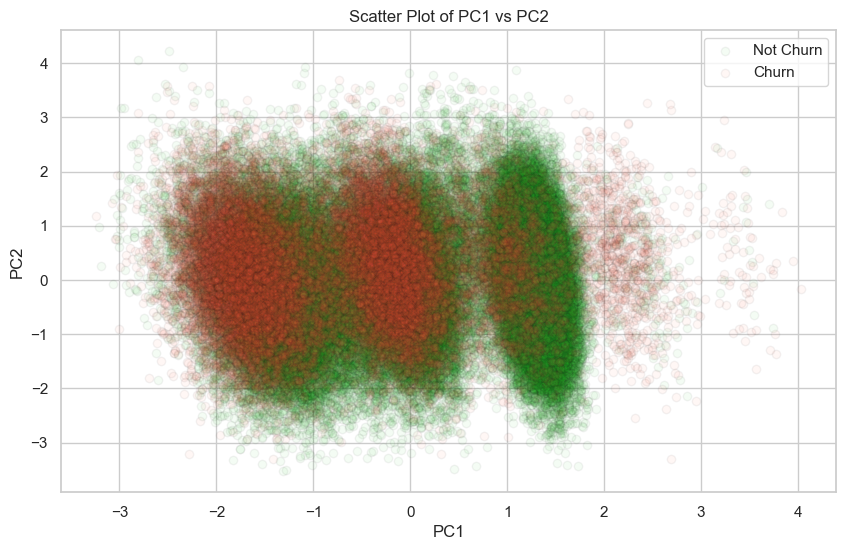

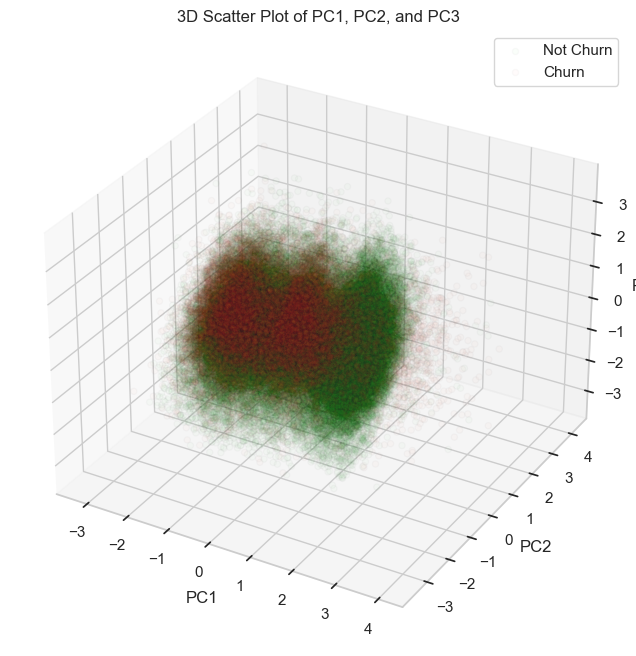

In [53]:
PC1 = X_pca['PC1']
PC2 = X_pca['PC2']
PC3 = X_pca['PC3']
y = y_train.squeeze()

# Plot scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(PC1[y == 0], PC2[y == 0], color='limegreen', alpha=0.05, label='Not Churn', edgecolor='k')
plt.scatter(PC1[y == 1], PC2[y == 1], color='tomato', alpha=0.05, label='Churn', edgecolor='k')
plt.title('Scatter Plot of PC1 vs PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

# Plot 3D graph
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(PC1[y == 0], PC2[y == 0], PC3[y == 0], color='limegreen', alpha=0.02, label='Not Churn', edgecolor='k')
ax.scatter(PC1[y == 1], PC2[y == 1], PC3[y == 1], color='tomato', alpha=0.02, label='Churn', edgecolor='k')
ax.set_title('3D Scatter Plot of PC1, PC2, and PC3')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

From the above 2D and 3D graphs, it is clear that **PCA is not very helpful in distinguishing customers who churn from those who do not churn**. Only PC1 is able to distinguish a little bit, but the separation is not substantial. This could be due to the fact that PCA is a linear dimensionality reduction technique, and it captures the directions of maximum variance in the data. However, the variance in the data might not correspond to the class separation between churn and non-churn customers. This implies that the underlying structure separating the two classes could be non-linear and more complex than what PCA can capture.

In [52]:
# Apply downsampling on X_pca and y_train
X_pca_balanced_unsup, y_train_balanced_unsup = downsampling(X_pca, y_train)

# Construct and fit a stacking model
stack_clf = StackingClassifier(estimators=base_estimators, final_estimator=final_estimator, cv=5)
stack_clf.fit(X_pca_balanced_unsup, y_train_balanced_unsup)

# Calculate roc_auc score
auc_scores = cross_val_score(stack_clf, X_pca_balanced_unsup, y_train_balanced_unsup, cv=5, scoring='roc_auc')

# Print score of every fold and average score
print(f"AUC Scores: ", auc_scores)
print("Average AUC Score: ", auc_scores.mean())

AUC Scores:  [0.87122301 0.87213226 0.87624642 0.86895118 0.86946991]
Average AUC Score:  0.8716045571888011


The performance of **supervised model using the PCA result is 0.8716, which drops compared with the original model**. This corresponds to the above analysis of PCA.

## **5.3 PCA first, K-means Clustering after**

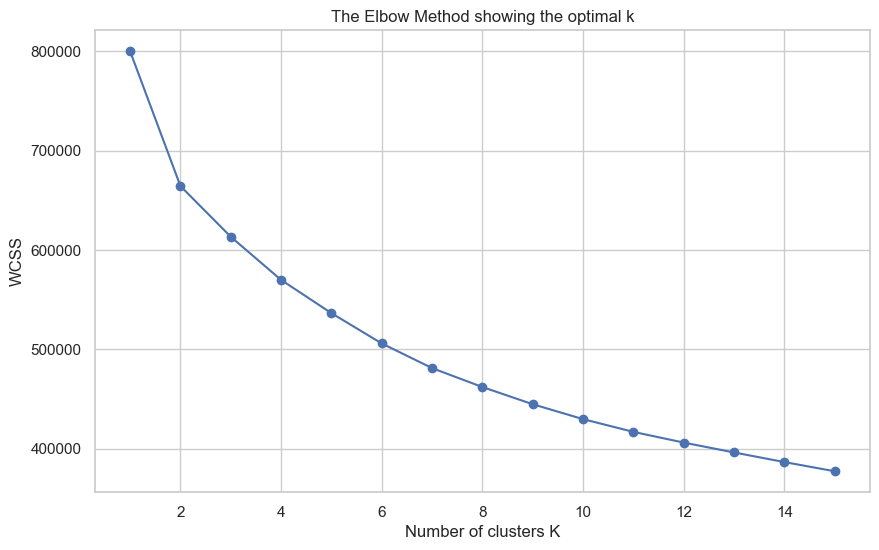

In [50]:
# Choose K using Elbow Method
plot_elbow(X_pca)

Using PCA result to apply clustering, there is not a distinct elbow point, either. The following uses different values of K to test which improve the performance of the supervised model.

In [54]:
# Iterate through different values of k: 4986s
for k in range(2, 8):
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    # Add clustering result into training and testing data
    X_pca['Cluster'] = kmeans.fit_predict(X_pca)
    X_test_pca['Cluster'] = kmeans.predict(X_test_pca)

    # Apply downsampling
    X_pca_balanced_unsup, y_train_balanced_unsup = downsampling(X_pca, y_train)

    # Construct and fit a stacking model
    stack_clf = StackingClassifier(estimators=base_estimators, final_estimator=final_estimator, cv=5)
    stack_clf.fit(X_pca_balanced_unsup, y_train_balanced_unsup)

    # Calculate roc_auc score
    auc_scores = cross_val_score(stack_clf, X_pca_balanced_unsup, y_train_balanced_unsup, cv=5, scoring='roc_auc')

    # Print score of every fold and average score
    print(f"AUC Scores for k={k}: ", auc_scores)
    print("Average AUC Score: ", auc_scores.mean())

    # Remove 'Cluster' for the next iteration
    X_pca.drop(columns='Cluster', inplace=True)
    X_test_pca.drop(columns='Cluster', inplace=True)

AUC Scores for k=2:  [0.87250053 0.87291849 0.87769653 0.86972795 0.87055374]
Average AUC Score:  0.8726794480646956
AUC Scores for k=3:  [0.87343467 0.87316603 0.87723483 0.87004476 0.87090682]
Average AUC Score:  0.8729574200674606
AUC Scores for k=4:  [0.87333557 0.87292808 0.87784636 0.86967984 0.87126675]
Average AUC Score:  0.873011322746201
AUC Scores for k=5:  [0.87246186 0.87277966 0.87770728 0.87019579 0.87110306]
Average AUC Score:  0.8728495296112333
AUC Scores for k=6:  [0.87273208 0.87306555 0.87786782 0.8694553  0.87105429]
Average AUC Score:  0.8728350083848723
AUC Scores for k=7:  [0.87231334 0.87296743 0.87758638 0.86923512 0.87051011]
Average AUC Score:  0.8725224747603727


Again, the model performance deteriorated after adding the unsupervised features.

# **6. Model Evaluation & Analysis**

## **6.1 Fit the Chosen Optimal Stacking Model:**

In [55]:
# Construct and fit a stacking model
stack_clf = StackingClassifier(estimators=base_estimators, final_estimator=final_estimator, cv=5)
stack_clf.fit(X_train_balanced, y_train_balanced)

StackingClassifier(cv=5,
                   estimators=[('lr',
                                LogisticRegression(C=0.01, random_state=42,
                                                   solver='liblinear')),
                               ('rf',
                                RandomForestClassifier(max_depth=10,
                                                       min_samples_split=5,
                                                       random_state=42)),
                               ('knn',
                                KNeighborsClassifier(metric='euclidean',
                                                     n_neighbors=15, p=1))],
                   final_estimator=LogisticRegression())

## **6.2 Model Evaluation**

In [56]:
# Predict using the stacking model
y_prob = stack_clf.predict_proba(X_test)[:, 1]  # Obtain the probabilities of positive (1)

# Predict class labels for the test set
y_pred = stack_clf.predict(X_test)

# Calculate roc_auc score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.6f}")

# Generate the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

ROC-AUC Score: 0.886400
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.81      0.87     39133
           1       0.52      0.80      0.63     10378

    accuracy                           0.80     49511
   macro avg       0.73      0.80      0.75     49511
weighted avg       0.85      0.80      0.82     49511



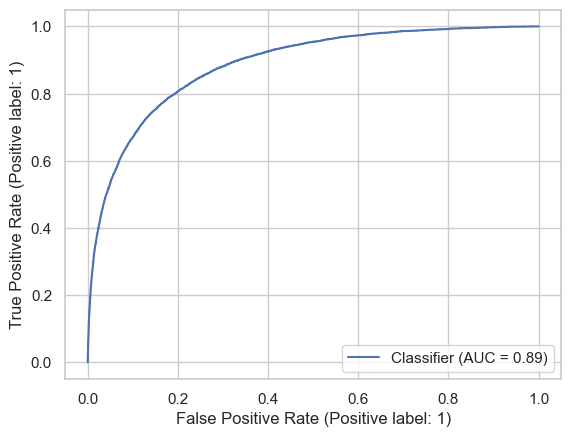

In [57]:
# Display ROC curve
RocCurveDisplay.from_predictions(y_test, y_prob)


#### ROC-AUC Score
- **0.8864**
  - Indicates strong discriminatory ability between churn and non-churn customers.

#### Precision, Recall, and F1-Score
These metrics provide a better understanding of model performance on imbalanced data.

##### Class 0 (Non-Churn)
- **Precision: 0.94**
  - 94% of predicted non-churn instances are correct.
- **Recall: 0.81**
  - 81% of actual non-churn instances are correctly identified.
- **F1-Score: 0.87**
  - Good balance between precision an# recall.

##### Class 1 (Churn)
- **Precision: 0.52**
  - 52% of predicted churn instances are correct.
- **Recall: 0.80**
  - 80% of actual churn instances are correctly identified.
- **F1-Score: 0.63**
  - Shows a trade-off between precision and recall.

#### Overall Performance
- **Accuracy: 0.80**
  - Accuracy is less reliable due to class imbalance.
- **Macro Average**:
  - **Precision: 0.73**, **Recall: 0.80**, **F1-Score: 0.75**
  - Treats each class equally, providing an overall performance measure.
- **Weighted Average**:
  - **Precision: 0.85**, **Recall: 0.80**, **F1-Score: 0.82**
  - Accounts for class imbalance, providin performance on the minority class (churn).

### **6.3 Error Analysis**

In [75]:
# Identify misclassified samples
misclassified_indices = (y_pred != y_test.squeeze())

# Extract misclassified samples from X_test and y_test
X_misclassified = X_test[misclassified_indices]
y_misclassified = y_test[misclassified_indices]
y_pred_misclassified = y_pred[misclassified_indices]

# Create a DataFrame for easier analysis
misclassified_df = pd.DataFrame(X_misclassified, columns=X_test.columns)
misclassified_df['True Label'] = y_misclassified
misclassified_df['Predicted Label'] = y_pred_misclassified
misclassified_df.shape

(9659, 15)

In [73]:
# Look for patterns in the misclassified samples
pattern_analysis = misclassified_df.groupby(['True Label', 'Predicted Label']).size().reset_index(name='Counts')
print("Pattern Analysis:\n", pattern_analysis)

Pattern Analysis:
    True Label  Predicted Label  Counts
0           0                1    7582
1           1                0    2077


In [74]:
misclassified_df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard,IsActiveMember,True Label,Predicted Label
count,9659.000000,9659.000000,9659.000000,9659.000000,9659.000000,9659.000000,9659.000000,9659.000000,9659.000000,9659.000000,9659.000000,9659.000000,9659.000000,9659.000000,9659.000000
mean,-0.026957,0.315031,-0.028509,0.331976,-0.597615,-0.037657,0.464230,0.332333,0.203437,0.528833,0.471167,0.722332,0.390413,0.215033,0.784967
std,1.048831,1.033138,1.013076,0.991838,0.830157,1.023473,0.498745,0.471074,0.402576,0.499194,0.499194,0.447872,0.487868,0.410866,0.410866
min,-3.809512,-2.271851,-1.786749,-0.875434,-1.017052,-2.230638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.779229,-0.352048,-1.073424,-0.875434,-1.017052,-0.809401,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,-0.006070,0.212600,-0.003436,0.725191,-1.017052,0.039726,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.679796,0.890178,0.709889,1.160012,-1.017052,0.827178,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,2.425638,6.084940,1.779877,3.125753,4.475049,1.743867,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The above summary statistics of misclassified observations indicate several patterns in the model's errors. Specifically, the model tends to misclassify customers whose `Age` and `Balance` are above average. Additionally, the percentage of observations who are active members is around 50% in the overall dataset, whereas in the misclassified group, the average of `IsActiveMember` is around 39%. This suggests that the model often makes mistakes when the customer is not an active member. Furthermore, the model tends to misclassify when the number of products a customer holds is less than average, with the average `NumOfProducts` being -0.598.

#### **Potential Improvement Strategy**

**Create Interative Features**: Develop new features that capture the interaction between Age, Balance, and IsActiveMember. For instance, create a feature that combines Age and Balance to see if older customers with higher balances have distinct patterns.

**Resampling Techniques**: Use more advanced techniques like SMOTE (Synthetic Minority Over-sampling Technique)to balance the dataset, especially if certain classes are underrepresented in the misclassified samples.

**Hyperparameter Tuning**: Conduct a more thorough hyperparameter tuning using techniques like grid search or random search to find the optimal settings for the model.
